| **Chapter**                   | 3:  Host factors              |
| ----------------------------- |-------------------------------|
| **Computational Note**        | 3.x: Contact matrix inference |
| **Package prerequisites**     | `scipy.integrate`             |



# Contact matrix inference

In this notebook, we will be creating synthetic contact matrices using a simplified version of the method described in Mistry _et al_. (2021).[^1] We will create only the household submatrix.


[^1]: Mistry, D., Litvinova, M., Pastore y Piontti, A. et al. Inferring high-resolution human mixing patterns for disease modeling. Nat Commun 12, 323 (2021). https://doi.org/10.1038/s41467-020-20544-y



In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import itertools
import colorcet as cc
from collections import Counter, defaultdict
import scipy.sparse as sp
from tqdm.notebook import trange, tqdm
import seaborn as sns

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

# Generating the synthetic households

In [2]:
household_df = pd.read_csv("usa_00004.csv")

In [3]:
# Filtering out non-relatives, institutional settings etc.

household_df = household_df[household_df.RELATE <= 10]

In [4]:
heads_of_household = household_df[household_df.RELATE == 1]
spouses = household_df[household_df.RELATE == 2]
children = household_df[household_df.RELATE == 3]
others = household_df[~household_df.RELATE.isin([1, 2, 3])]

In [5]:
# Appending spousal age to HoHs to infer

heads_of_household = heads_of_household.merge(spouses[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_spouse"))

In [6]:
# Data frame for children as a function of their parents' ages

age_children = children.merge(heads_of_household[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_hhp")).merge(spouses[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_spp"))

In [7]:
age_others = others.merge(heads_of_household[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_hhp")).merge(spouses[["AGE", "SERIAL"]], on="SERIAL", how="left", suffixes=("", "_spp"))

In [8]:
# Data frame for the number of children as a function of their parents' ages

heads_of_household = children.groupby("SERIAL").count()["CBSERIAL"].reset_index().rename(columns={"CBSERIAL": "count_children"}).merge(heads_of_household, on="SERIAL", how="right")

In [9]:
heads_of_household = others.groupby("SERIAL").count()["CBSERIAL"].reset_index().rename(columns={"CBSERIAL": "count_others"}).merge(heads_of_household, on="SERIAL", how="right")

In [10]:
def generate_household(tolerance=2):
    household_size = household_df.FAMSIZE.sample().values[0]
    
    hoh_age = heads_of_household[heads_of_household.FAMSIZE == household_size].AGE.sample(1).values[0]
    
    relations_ages = []
    
    if household_size > 1:
        remaining_to_allocate = household_size - 1

        hoh_age_cohort = heads_of_household[heads_of_household.AGE.between(hoh_age - tolerance,
                                                                           hoh_age + tolerance)]
        
        spouse_age = hoh_age_cohort["AGE_spouse"].sample(1).values[0]
        if not np.isnan(spouse_age):
            relations_ages.append(spouse_age)
            remaining_to_allocate -= 1
            
        if remaining_to_allocate:
            children_others_ratio = hoh_age_cohort.count_children.count()/(
                hoh_age_cohort.count_children.count() + hoh_age_cohort.count_others.count()
            )
            
            if not np.isnan(spouse_age):
                # if spouse, then the child's age is determined by both parents' ages
                allocatable_children = age_children[(age_children.AGE_hhp.between(hoh_age - tolerance,
                                                                                 hoh_age + tolerance)) & 
                                                    (age_children.AGE_spp.between(spouse_age - tolerance,
                                                                                  spouse_age + tolerance))]
                allocatable_others = age_others[(age_others.AGE_hhp.between(hoh_age - tolerance,
                                                                                 hoh_age + tolerance)) & 
                                                    (age_others.AGE_spp.between(spouse_age - tolerance,
                                                                                  spouse_age + tolerance))]
            
            else:
                allocatable_children = age_children[age_children.AGE_hhp.between(hoh_age - tolerance,
                                                                                 hoh_age + tolerance)]
                allocatable_others = age_others[age_others.AGE_hhp.between(hoh_age - tolerance,
                                                                                 hoh_age + tolerance)]

                
            while remaining_to_allocate:
                if (np.random.rand() < children_others_ratio or len(allocatable_others) == 0) and len(allocatable_children) > 0:
                    # allocate a child
                    relations_ages.append(allocatable_children.sample(1).AGE.values[0])
                else:
                    if len(allocatable_others) > 0:
                        relations_ages.append(allocatable_others.sample(1).AGE.values[0])
                
                remaining_to_allocate -= 1
        
    return list(map(int, [hoh_age, *relations_ages]))

In [41]:
def generate_households(n=500, max_age:int=100, *args, **kwargs) -> np.array:
    household_cooccurrence_matrix = np.zeros((max_age, max_age))

    for i in trange(n):
        synthetic_household = generate_household(*args, **kwargs)
        for iidx, ival in enumerate(synthetic_household):
            for jidx, jval in enumerate(synthetic_household):
                if iidx != jidx:
                    ival = min(ival, max_age)
                    jval = min(jval, max_age)
                    household_cooccurrence_matrix[ival][jval] += 1
                    household_cooccurrence_matrix[jval][ival] += 1

    with np.errstate(divide="ignore", invalid="ignore"):
        result = np.true_divide(household_cooccurrence_matrix, household_cooccurrence_matrix.sum(axis=0))
        result[result == np.inf] = 0
        result = np.nan_to_num(result)

    return result

In [42]:
households_cm = generate_households(10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 0, 'To')

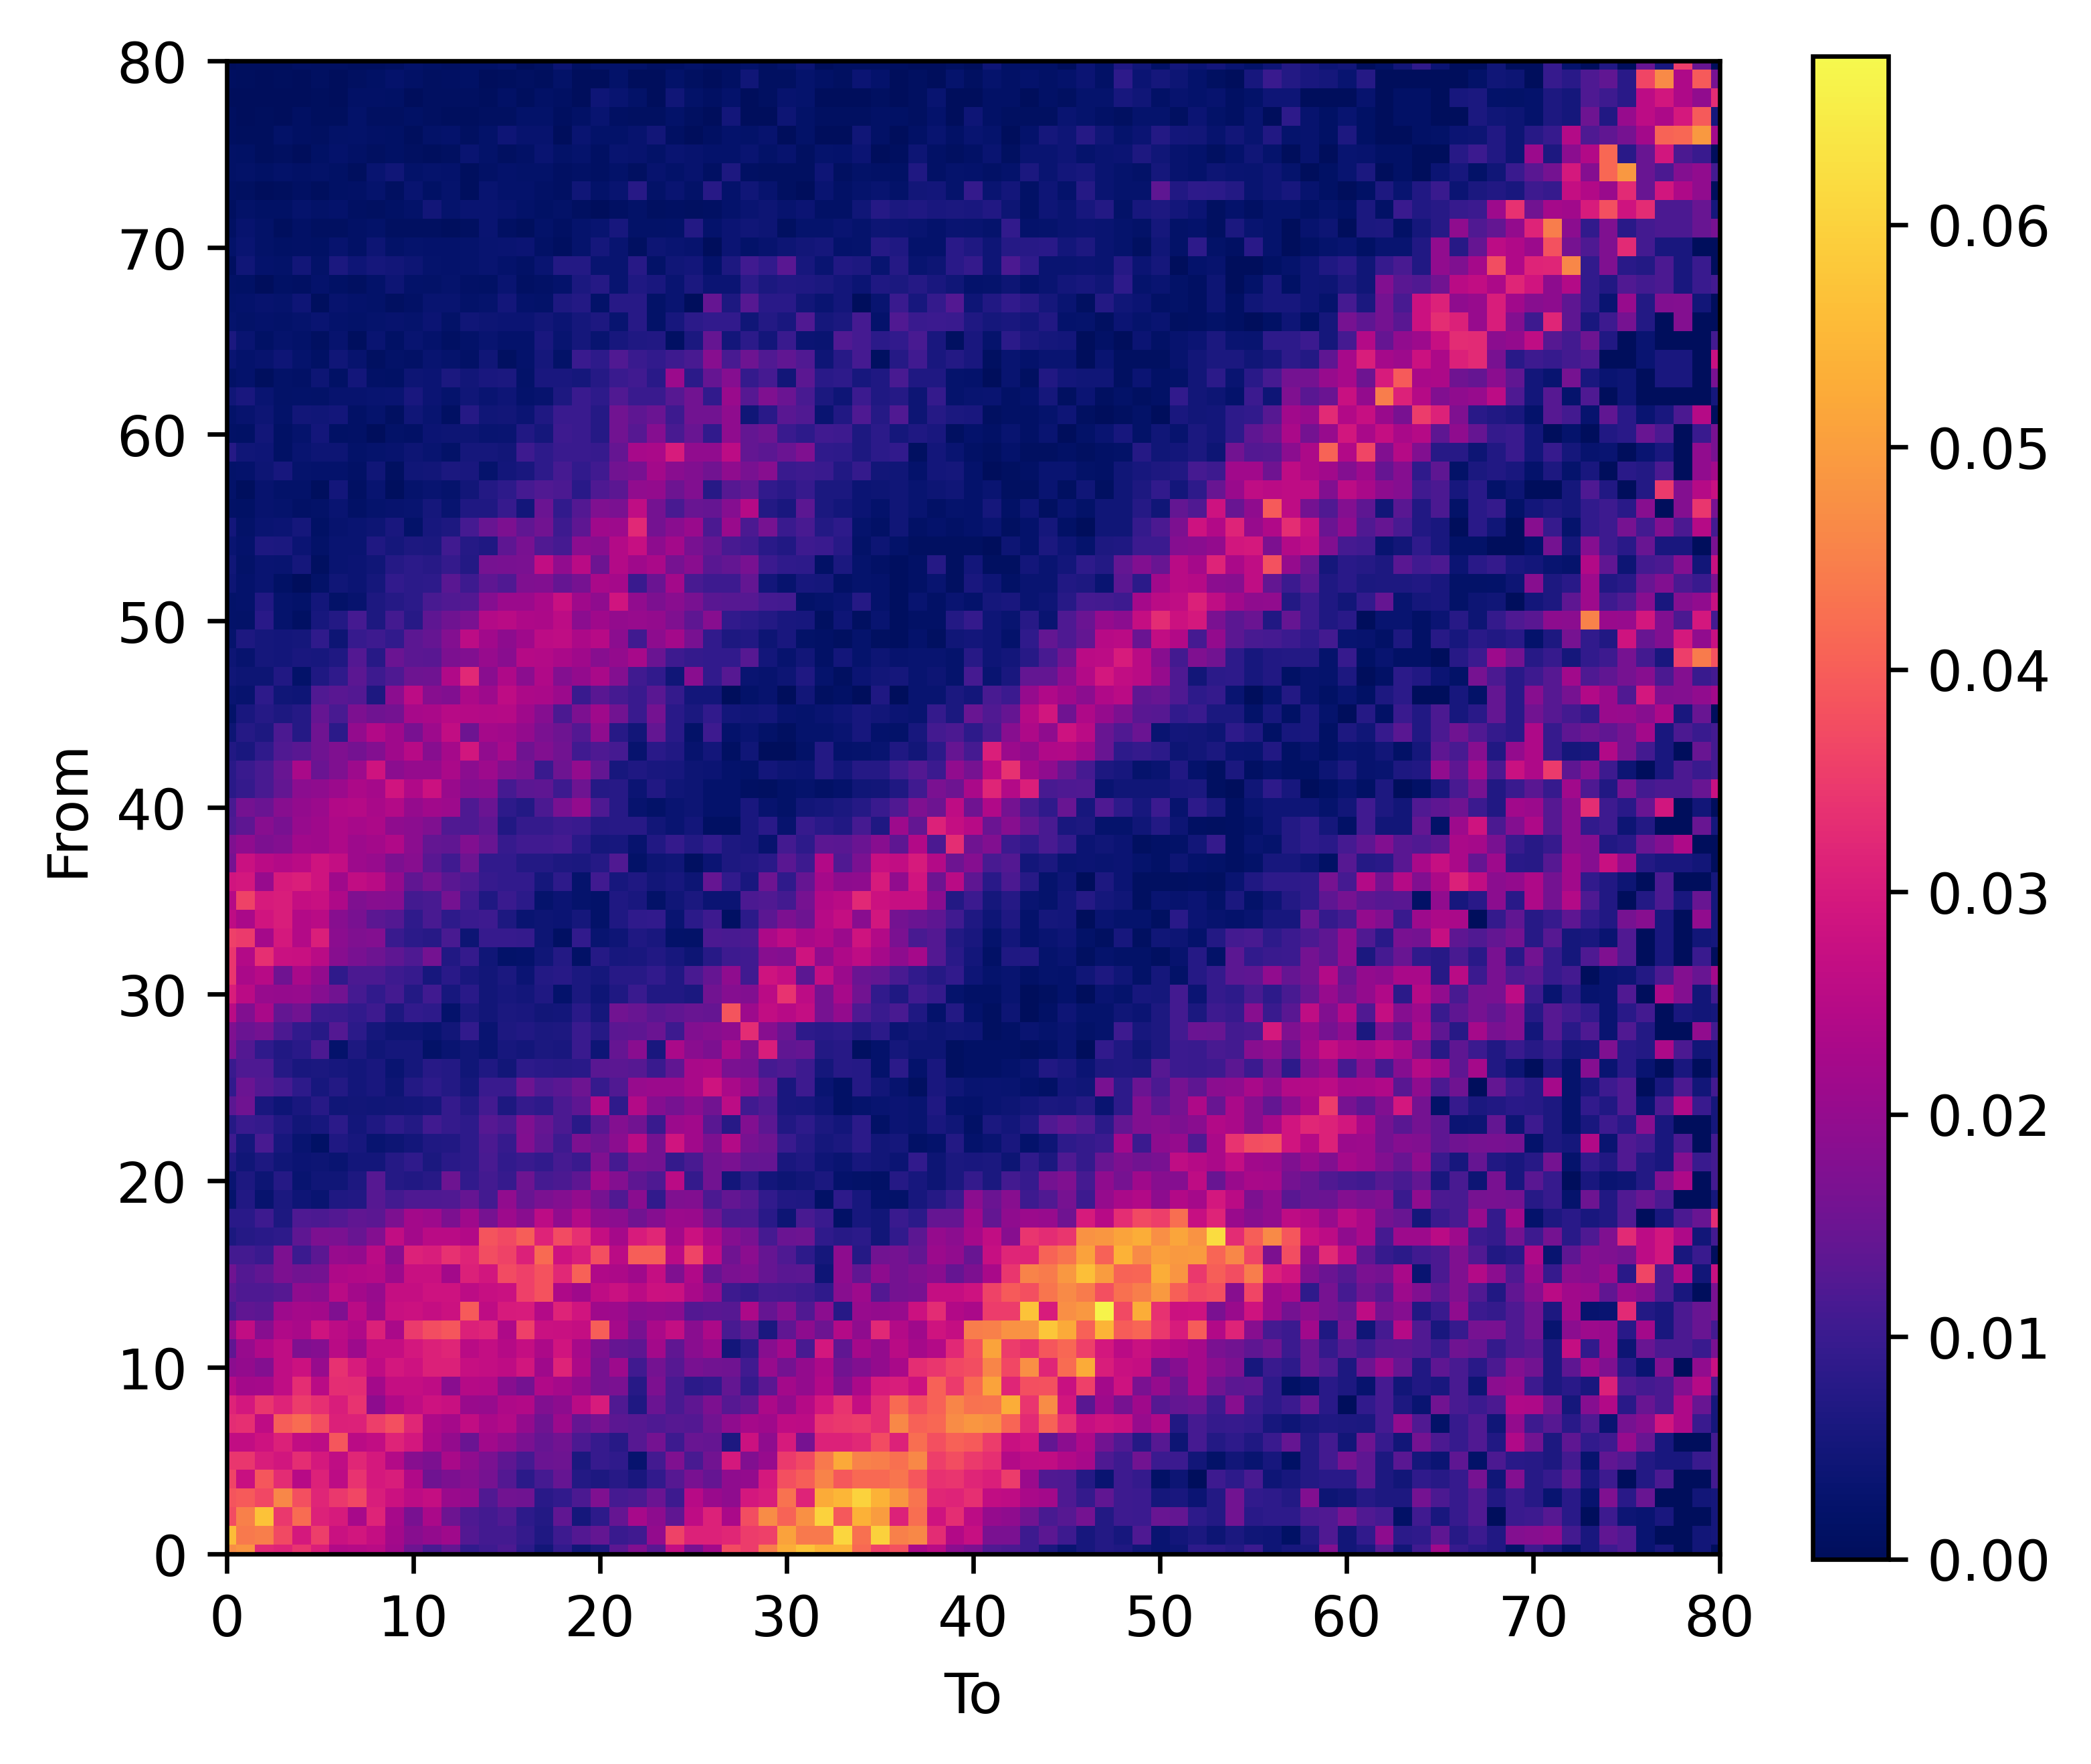

In [49]:
fig = plt.figure(figsize=(6, 6.2), dpi=600)

# Interpretation of the figure:
# The value at x,y is the relative likelihood of an interaction by someone of age y with someone of age x.

plt.imshow(households_cm, cmap=cc.cm.CET_L8)
plt.colorbar(shrink=0.8)
plt.ylim(0, 80)
plt.xlim(0, 80)
plt.ylabel("From")
plt.xlabel("To")

# Creating synthetic schools

In [103]:
fall_membership = pd.read_csv("fall_membership_statistics.csv")\
                      .iloc[:, 5:19]\
                      .replace(" ", 0)\
                      .applymap(lambda x: int(x.replace(",", "")) if type(x) is str else 0)

# Preselecting minors to speed up later indexing
pk_aged_population = household_df[household_df.AGE.between(3, 5)].AGE.to_list()
kg_aged_population = household_df[household_df.AGE.between(4, 5)].AGE.to_list()

In [104]:
# Teacher demographics:
# All in VA with EMPSTAT=1 (currently employed) whose OCC2010 code is:
# * 2300 Preschool and Kindergarten Teachers
# * 2310 Elementary and Middle School Teachers
# * 2320 Secondary School Teachers
# * 2330 Special Education Teachers

teacher_demographics = pd.read_csv("usa_00005.csv")

# We turn this into lists of ages that is faster to select.

ages_2300 = teacher_demographics[teacher_demographics.OCC2010 == 2300].AGE.to_list()
ages_2310 = teacher_demographics[teacher_demographics.OCC2010 == 2310].AGE.to_list()
ages_2320 = teacher_demographics[teacher_demographics.OCC2010 == 2320].AGE.to_list()
ages_2330 = teacher_demographics[teacher_demographics.OCC2010 == 2330].AGE.to_list()

# Manually garbage-collect teacher_demographics as we won't need it anymore.
del teacher_demographics

# The number of teachers is determined as follows:
# * EEOALL1R gives us the total number for the sets above (2018, ACS 5-year):
#   - 2300 Preschool and Kindergarten Teachers: 19,735
#   - 2310 Elementary and Middle School Teachers: 111,710
#   - 2320 Secondary School Teachers: 19,575
#   - 2330 Special Education Teachers: 7,040
#
# * Teachers are allocated as follows:
#   - 2300 series teachers are allocated proportionally as per sum of pre-K and KG population
#   - 2310 series teachers are allocated proportionally as per sum of grades 1 to 8 inclusive
#   - 2320 series teachers are allocated proportionally as per sum of grades 9 to 12 inclusive
#   - SEN teachers are allocated proportionally across grades 1 to 12



In [105]:
# Calculate the student-teacher ratios according to the above
total_2300s = 19_375
total_2310s = 111_710
total_2320s = 19_575
total_2330s = 7_040

STR_2300s = fall_membership.iloc[:, 0:2].sum().sum()/total_2300s
STR_2310s = fall_membership.iloc[:, 2:10].sum().sum()/total_2310s
STR_2320s = fall_membership.iloc[:, 10:14].sum().sum()/total_2320s
STR_2330s = fall_membership.iloc[:, 2:14].sum().sum()/total_2330s

In [129]:
def process_row(row: list, cooccurrence_matrix: np.array, max_age=80) -> list:
    """Processes a Fall Membership row into a synthetic school."""
    synthetic_school_population = []

    # Pre-K sample
    if row[0]:
        synthetic_school_population.append(random.choices(pk_aged_population, k=int(row[0])))

    # KG sample
    if row[1]:
        synthetic_school_population.append(random.choices(kg_aged_population, k=int(row[1])))

    for grade, count in enumerate(row[1:]):
        if grade:
            synthetic_school_population.append(np.repeat(grade + 6, count))

    teachers_2300 = (sum(row[0:2])//STR_2300s).astype("int")
    teachers_2310 = (sum(row[2:10])//STR_2310s).astype("int")
    teachers_2320 = (sum(row[10:14])//STR_2320s).astype("int")
    teachers_2330 = (sum(row[2:14])//STR_2330s).astype("int")

    teachers = random.choices(ages_2300, k=teachers_2300) \
                + random.choices(ages_2310, k=teachers_2310) \
                + random.choices(ages_2320, k=teachers_2320) \
                + random.choices(ages_2330, k=teachers_2330)

    synthetic_school_population.append(teachers)

    # We flatten the array
    synthetic_school_population = list(itertools.chain(*synthetic_school_population))

    for iidx, ival in enumerate(synthetic_school_population):
        for jidx, jval in enumerate(synthetic_school_population):
            if iidx != jidx:
                ival = min(ival, max_age)
                jval = min(jval, max_age)
                cooccurrence_matrix[ival][jval] += 1
                cooccurrence_matrix[jval][ival] += 1

    return cooccurrence_matrix

In [130]:
def generate_synthetic_school_matrix(max_age=100):
    school_cooccurrence_matrix = np.zeros((max_age, max_age))

    with tqdm(total=fall_membership.shape[0]) as pb:
        for idx, row in fall_membership.iterrows():
            school_cooccurrence_matrix = process_row(row, school_cooccurrence_matrix, max_age)
            pb.update(1)

    with np.errstate(divide="ignore", invalid="ignore"):
        result = np.true_divide(school_cooccurrence_matrix, school_cooccurrence_matrix.sum(axis=0))
        result[result == np.inf] = 0
        result = np.nan_to_num(result)

    return result

In [ ]:
schools_cm = generate_synthetic_school_matrix()

  0%|          | 0/1862 [00:00<?, ?it/s]

# Create synthetic workplaces

First, we ascertain the total employed population.
Then, we identify the likelihood that a person is employed as anything other than a teacher (whom we have of course already taken into account, using the microdata in `usa_00006.csv`: all samples from Virginia whose OCC2021 is not 2300, 2310, 2320 or 2330.